In [1]:
import sys
import json
import pickle
import matplotlib.pyplot as plt
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval_cvae import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, eval_single_system, get_metric_dataframes
from data.metrics import maximum_mean_discrepancy, wasserstein_distance

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v10'
split = 'system'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_2305494/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


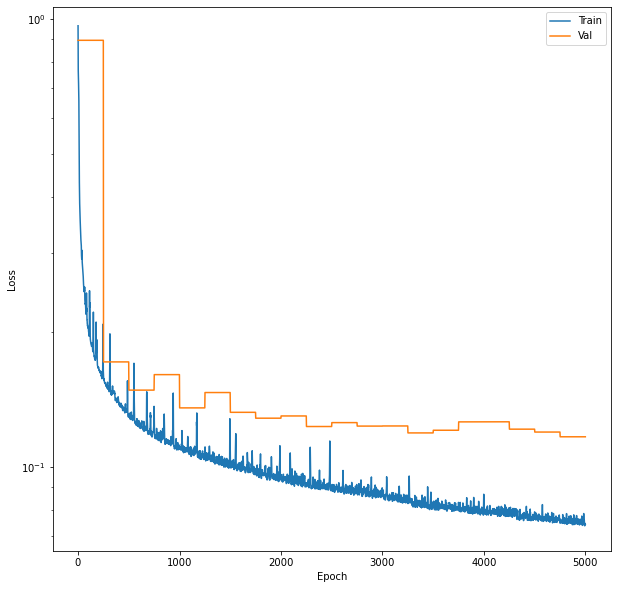

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Get predictions and ground truths
model, configs = load_model(model_type, fname, split)
syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset = get_prediction_and_ground_truths(model, configs)
mmd_zeo_agg_df, wsd_zeo_agg_df, mmd_zeo_osda_df, wsd_zeo_osda_df = get_metric_dataframes(configs)

Loading model and configs...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


# 1) Overall aggregated

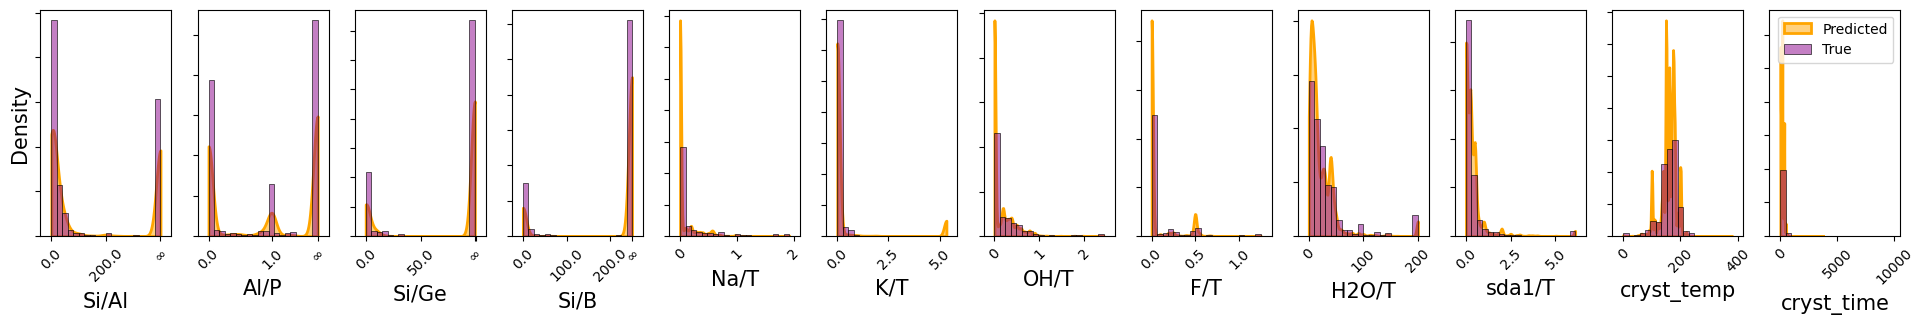

In [6]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], [True, False], [False, True], ['orange', 'darkmagenta'], common_norm=True, alpha=0.5)

# 2) System-splits

### A) Zeolite-aggregated systems

Calculating metrics for zeolite-aggregated systems...
CHA
MMD: 0.2270488739013672
WSD: 0.12340552846238957


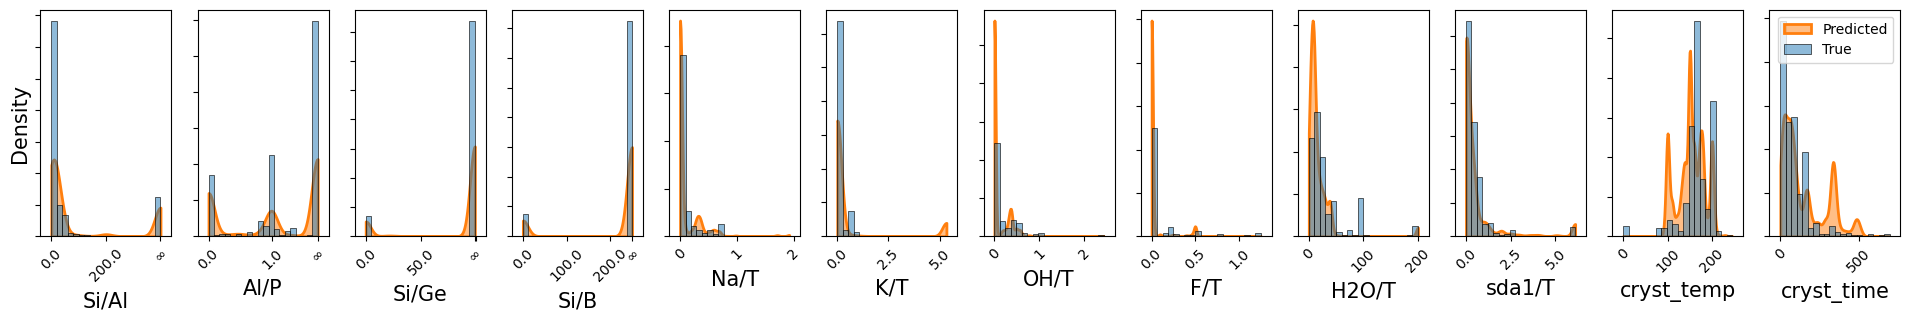

AEL
MMD: 0.27178192138671875
WSD: 0.05736703325006812


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


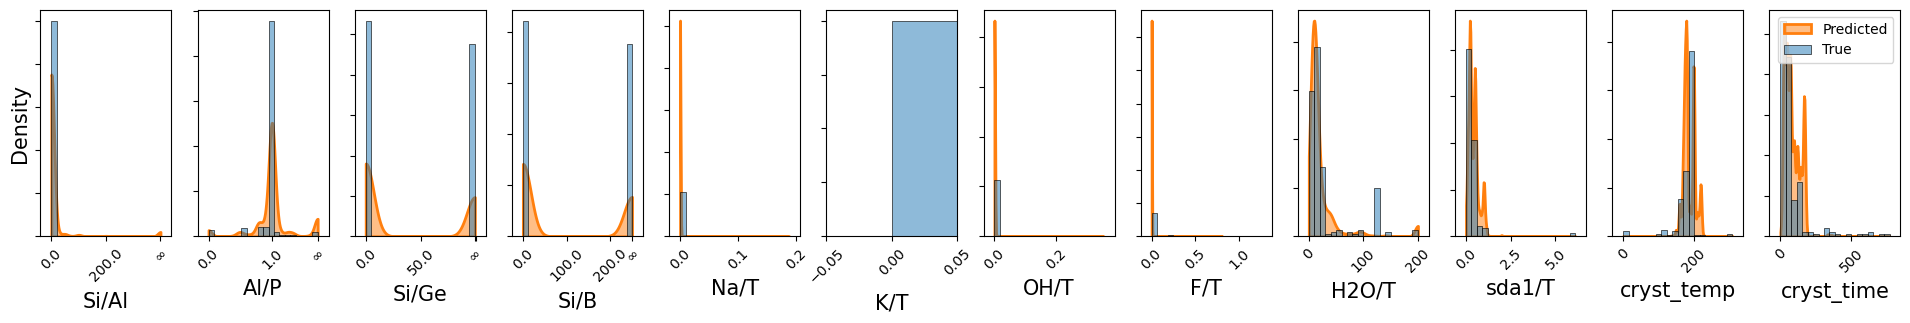

MFI
MMD: 0.1663188934326172
WSD: 0.1327364396861895


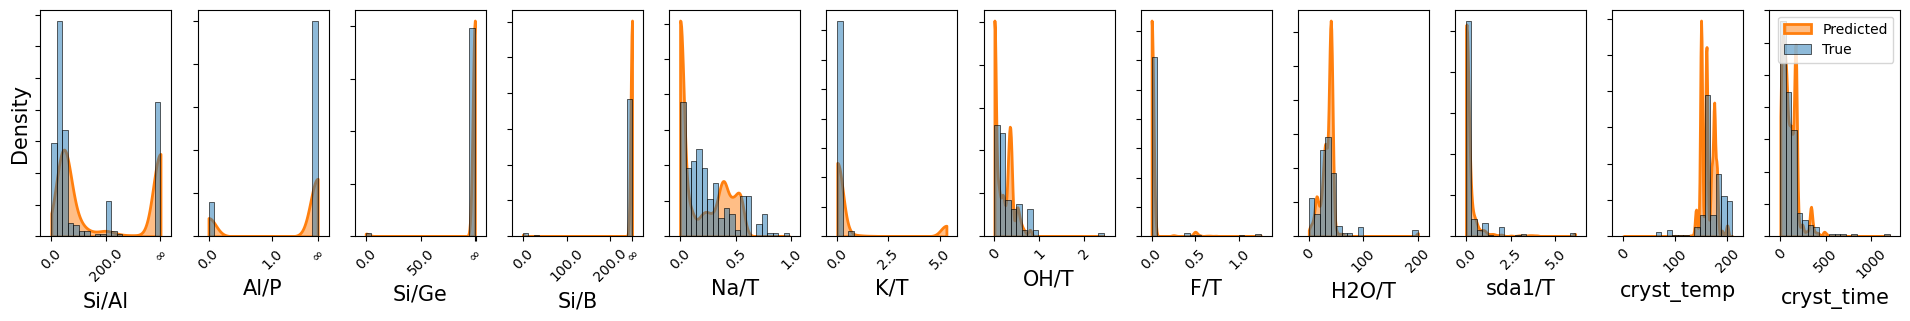

LTA
MMD: 0.15888166427612305
WSD: 0.11619775611799532


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


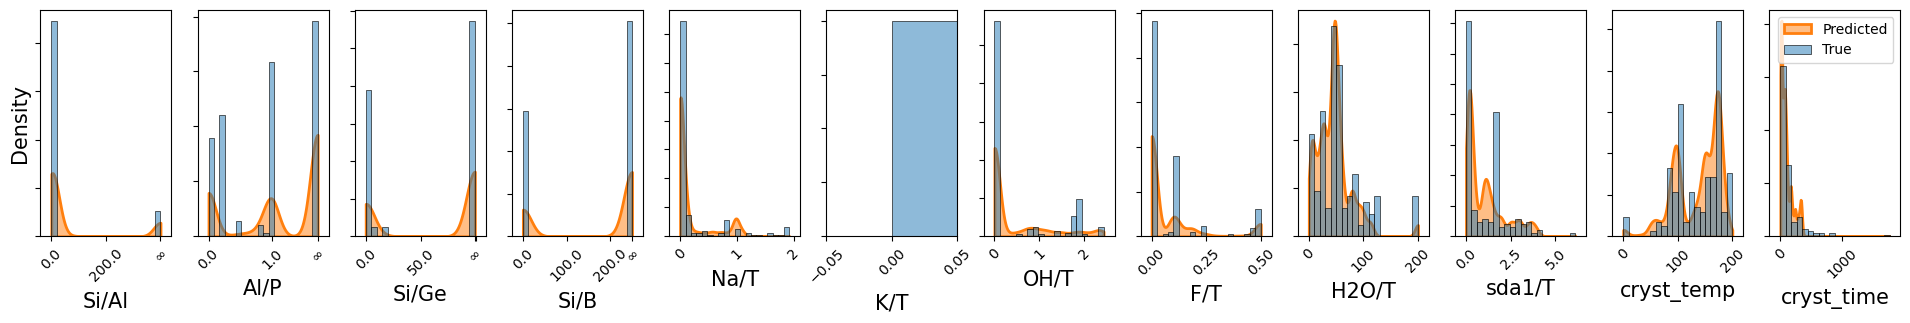

AFI
MMD: 0.031311988830566406
WSD: 0.0611221704642627


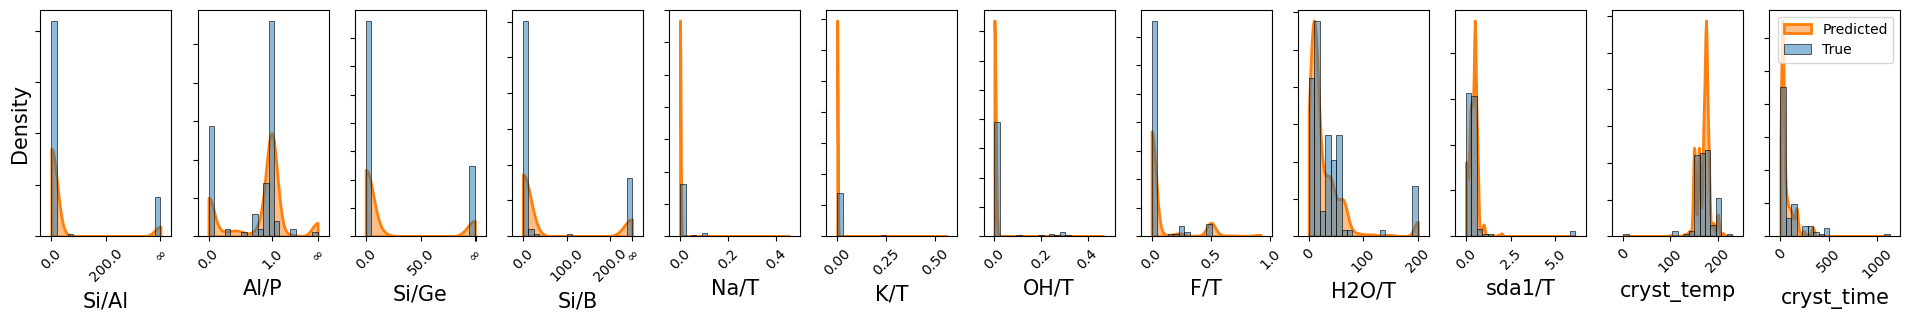

IWR
MMD: 0.5780611038208008
WSD: 0.2383899767663029


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


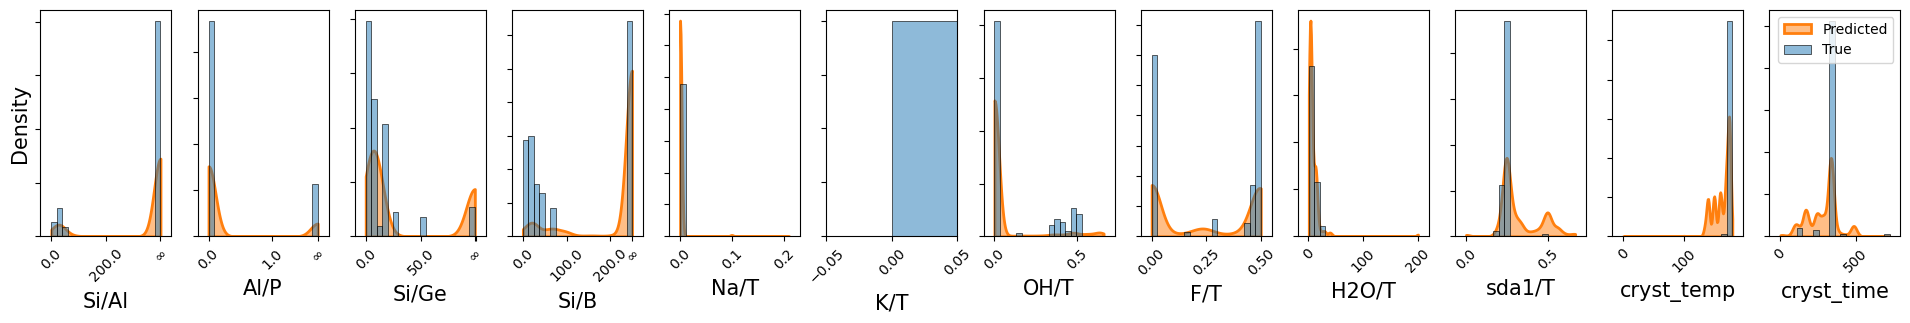

BEA
MMD: 0.05720996856689453
WSD: 0.052514567327067094


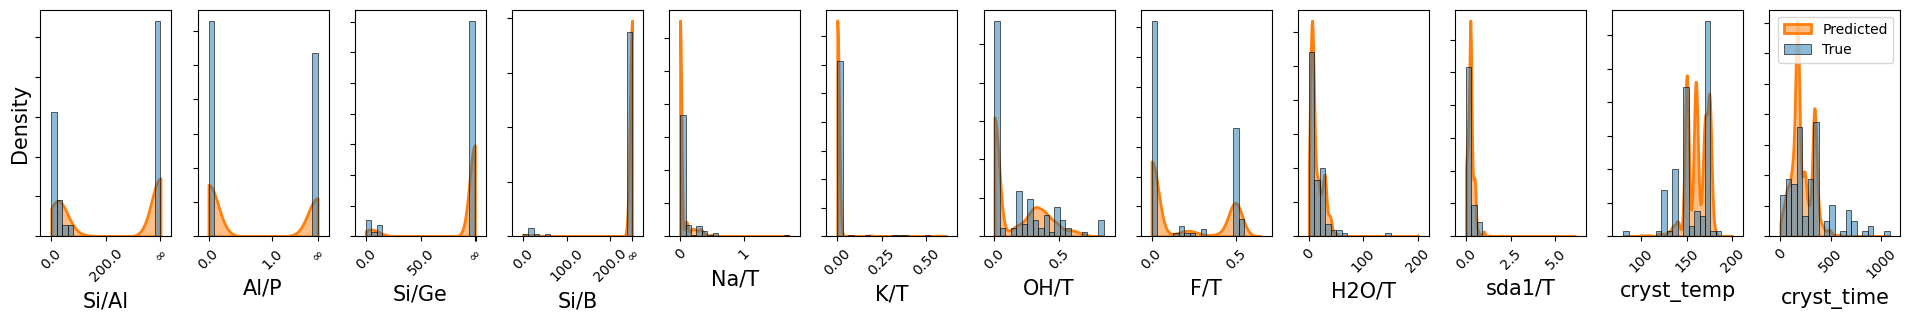

MTW
MMD: 0.08180713653564453
WSD: 0.07507459859876069


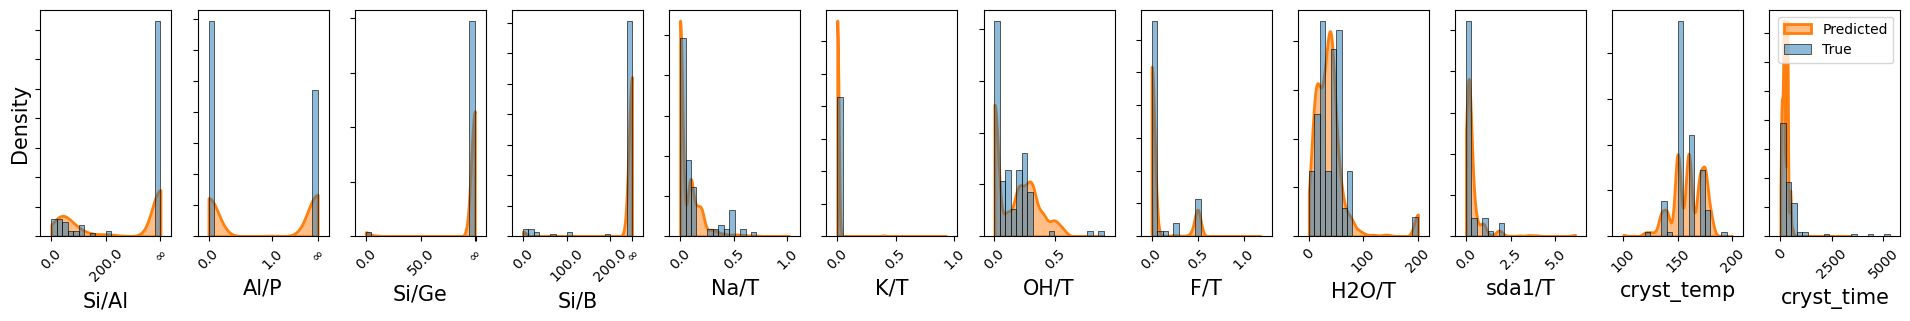

MEL
MMD: 0.22710227966308594
WSD: 0.10711350706580562


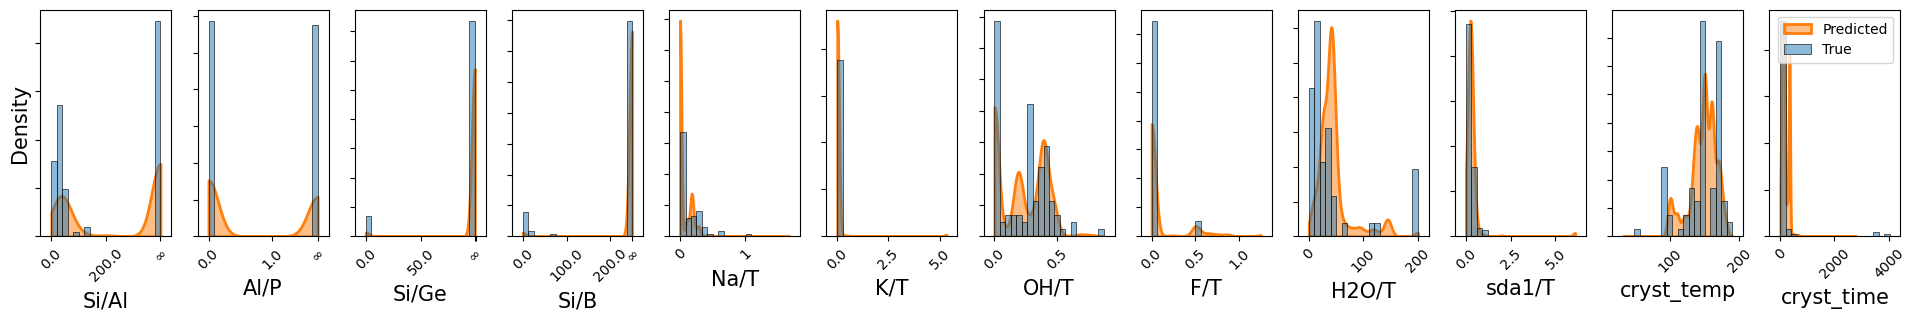

LEV
MMD: 0.3050107955932617
WSD: 0.11818846592282435


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


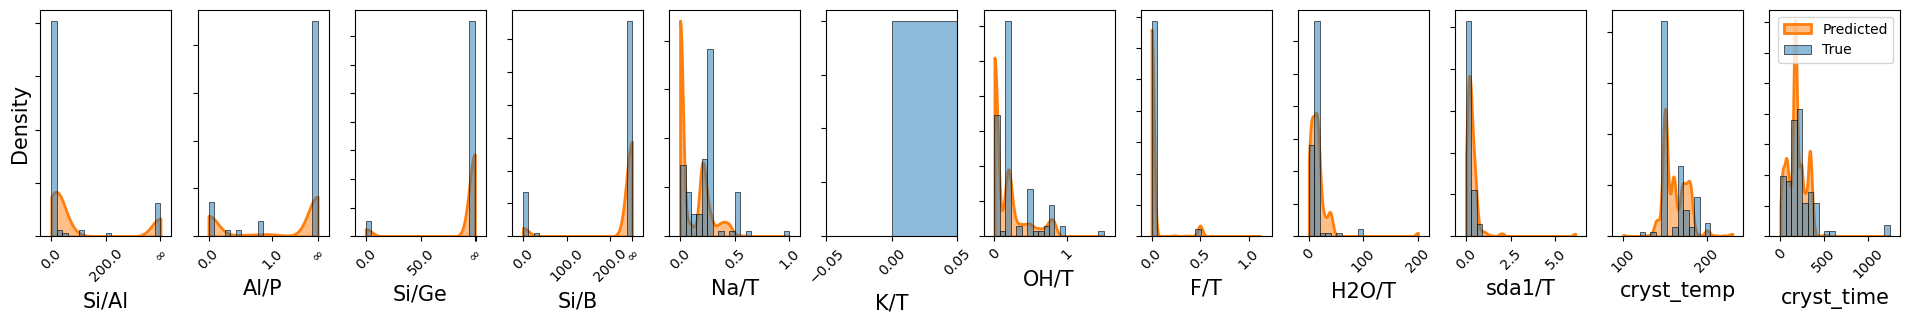

Mean MMD: 0.21045346260070802 Std MMD: 0.15815704629165284
Mean WSD: 0.10821100436616657 Std WSD: 0.05471751700163232


In [7]:
_, _ = eval_zeolite_aggregated(syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset, configs, eval=True, plot=True, print_metrics=True, num_systems=10)

SAV
MMD: 0.2758541107177734
WSD: 0.222753539651447


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


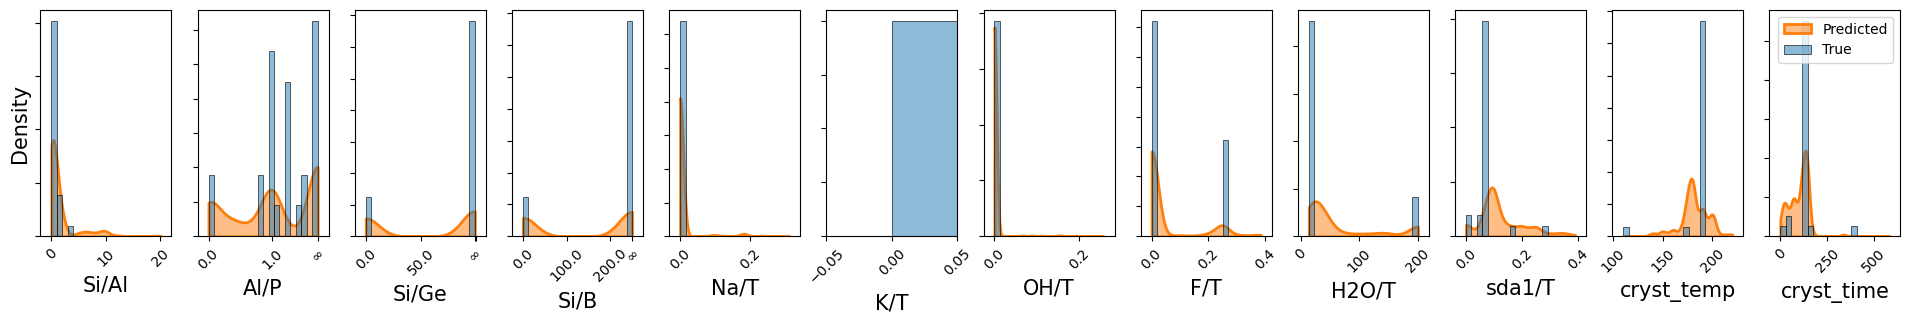

In [8]:
eval_single_system(syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset, mmd_zeo_agg_df, wsd_zeo_agg_df, mmd_zeo_osda_df, wsd_zeo_osda_df, zeo='SAV')

BEC
MMD: 0.1035661697387695
WSD: 0.0739224324042668


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


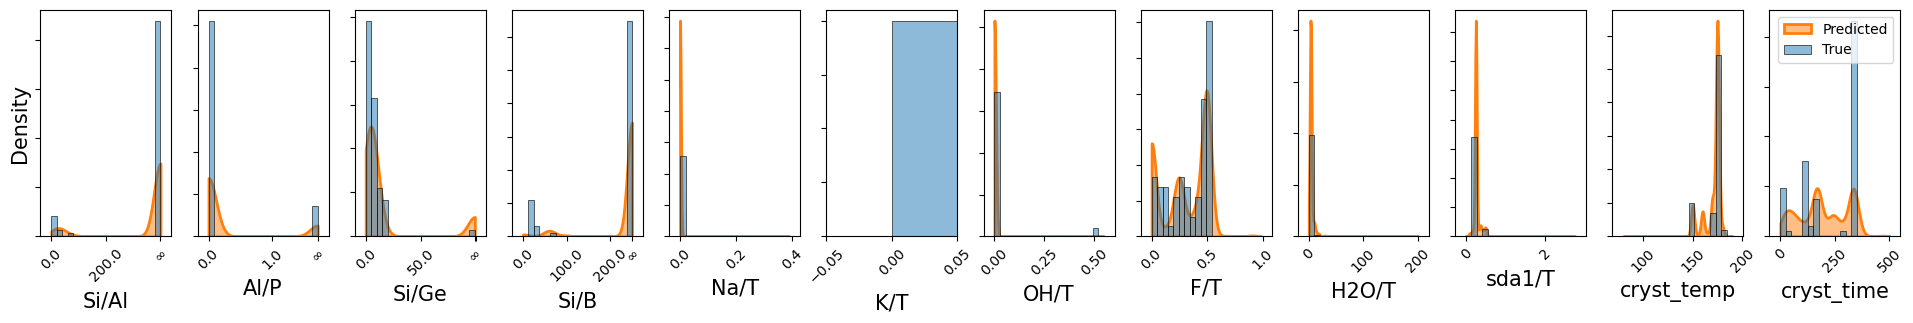

In [9]:
eval_single_system(syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset, mmd_zeo_agg_df, wsd_zeo_agg_df, mmd_zeo_osda_df, wsd_zeo_osda_df, zeo='BEC')

### B) Zeolite-OSDA system

Calculating metrics for zeolite-OSDA systems...
CHA C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
MMD: 0.6920938491821289
WSD: 0.18999613507598523


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


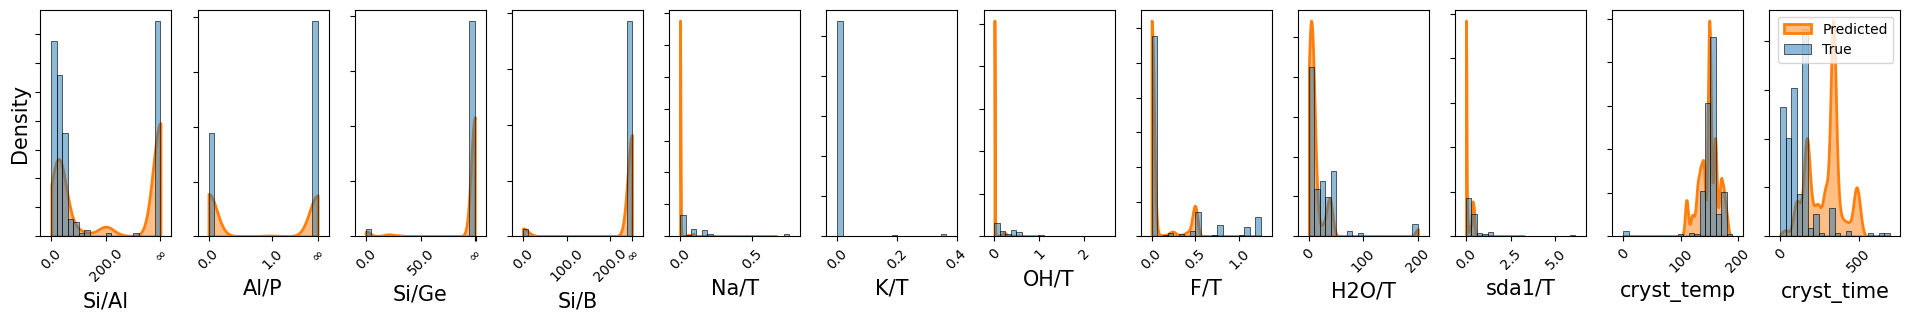

AEL CCCNCCC
MMD: 0.2834444046020508
WSD: 0.05290315179737008


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


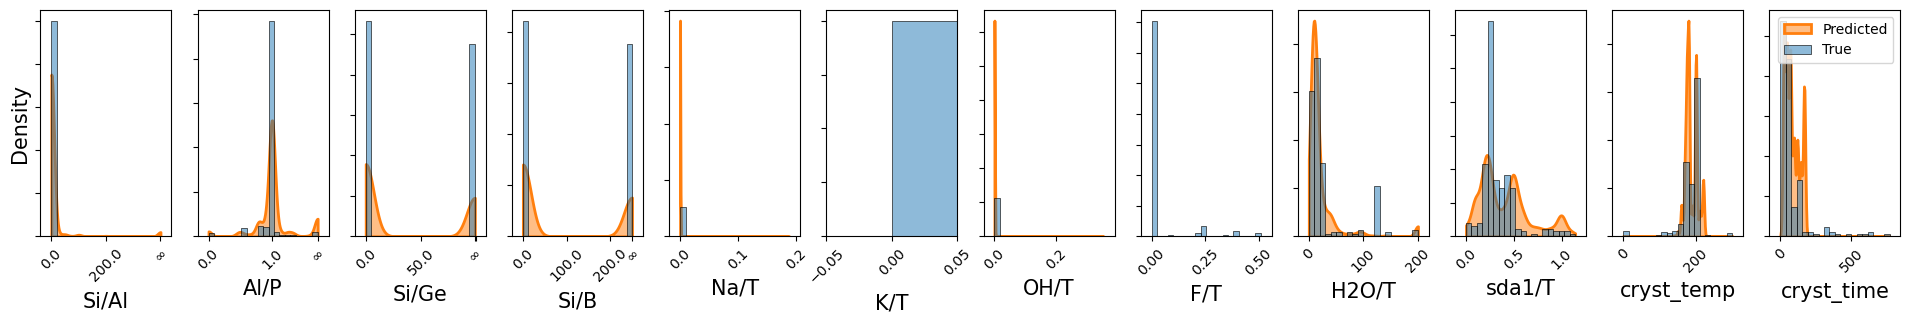

CHA OSDA-free
MMD: 0.8378486633300781
WSD: 0.24983306664867558


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


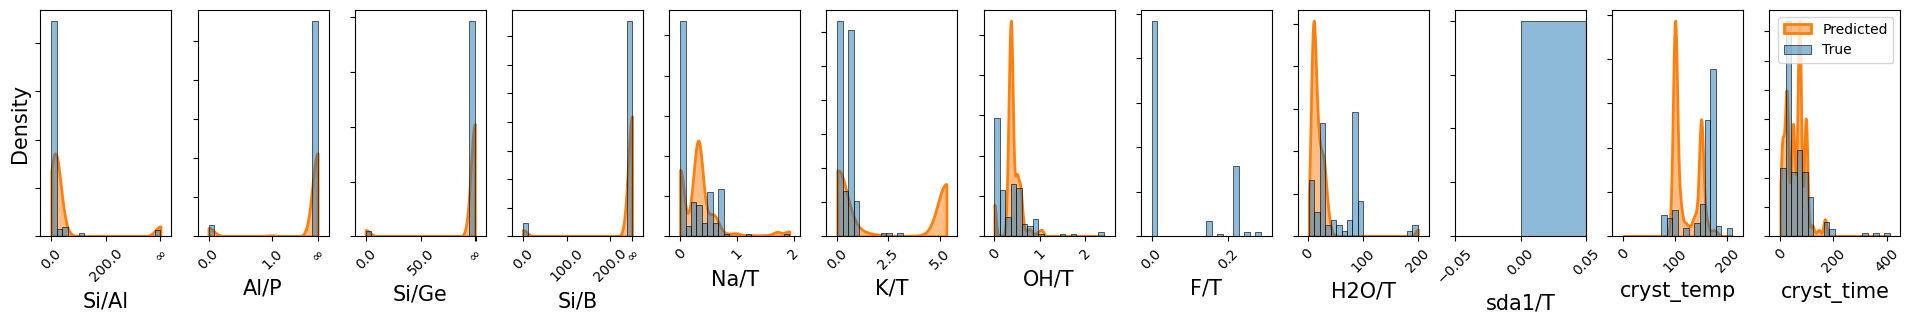

MFI OSDA-free
MMD: 0.34198665618896484
WSD: 0.2035970096360574


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


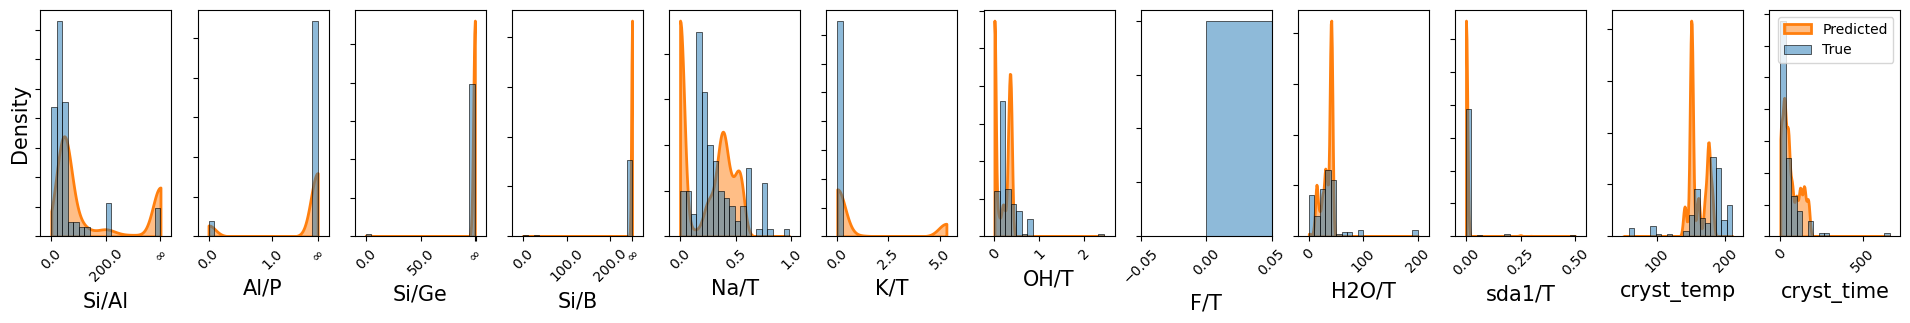

CHA CCN(CC)CC
MMD: 0.5357198715209961
WSD: 0.1404989807153839


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


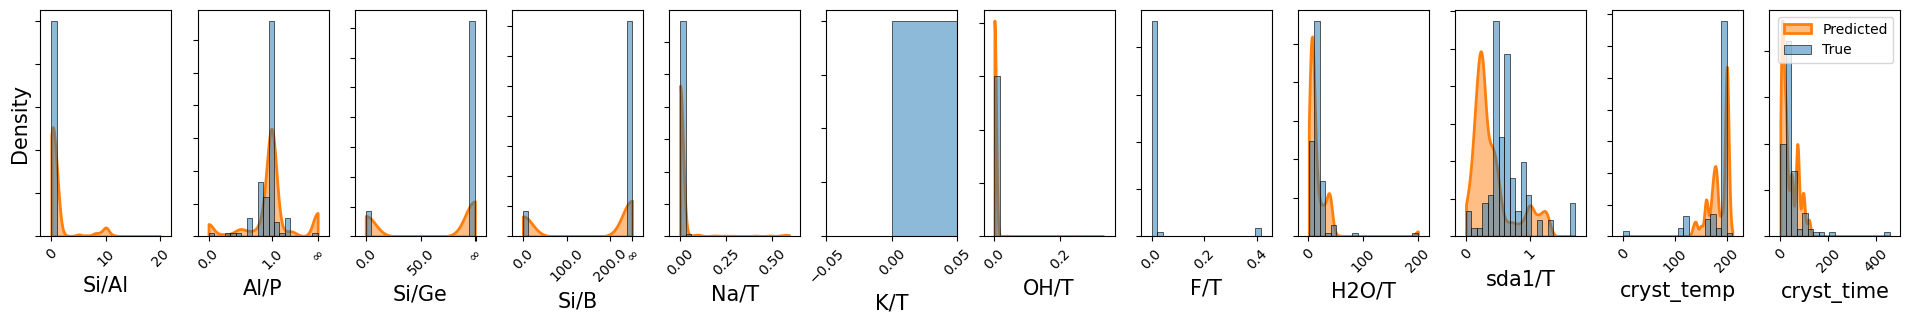

LTA C[N+](C)(C)C
MMD: 0.44031620025634766
WSD: 0.17585864127402678


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


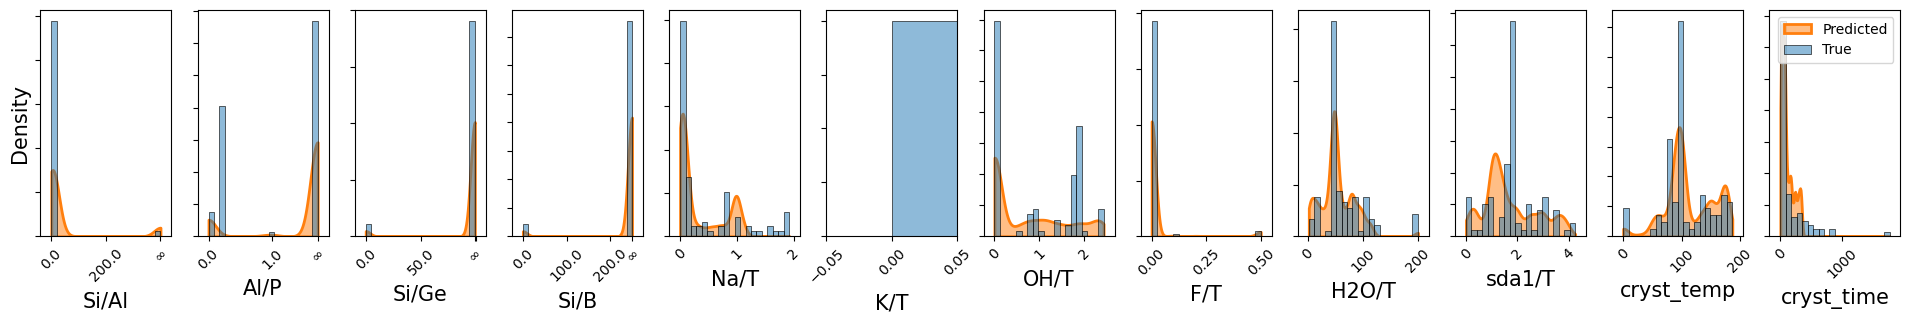

MEL CCCC[N+](CCCC)(CCCC)CCCC
MMD: 0.35811328887939453
WSD: 0.15567786481523893


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


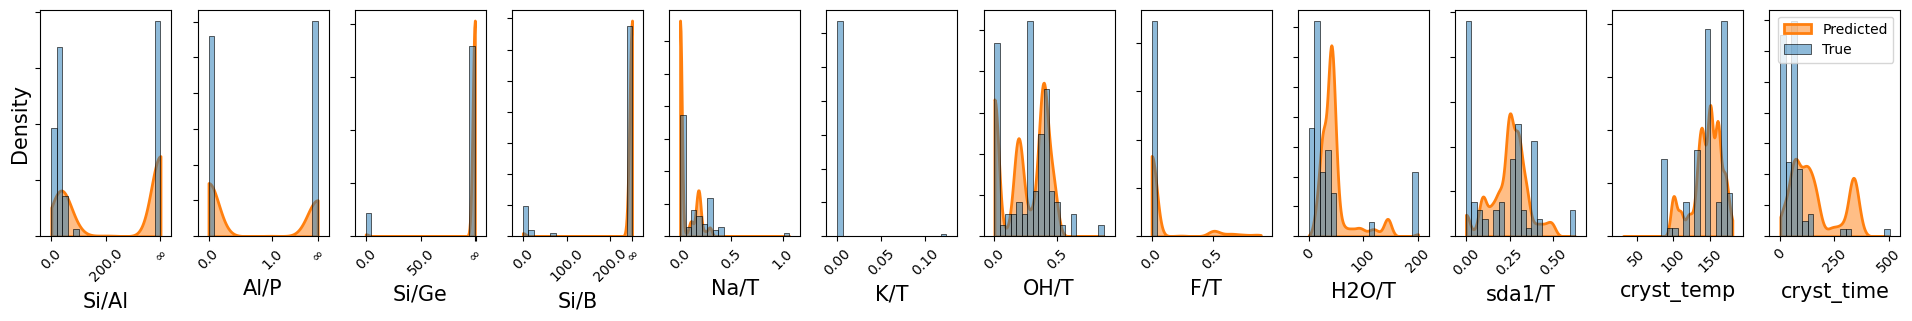

CHA C1COCCN1
MMD: 0.7555704116821289
WSD: 0.19611632307154456


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


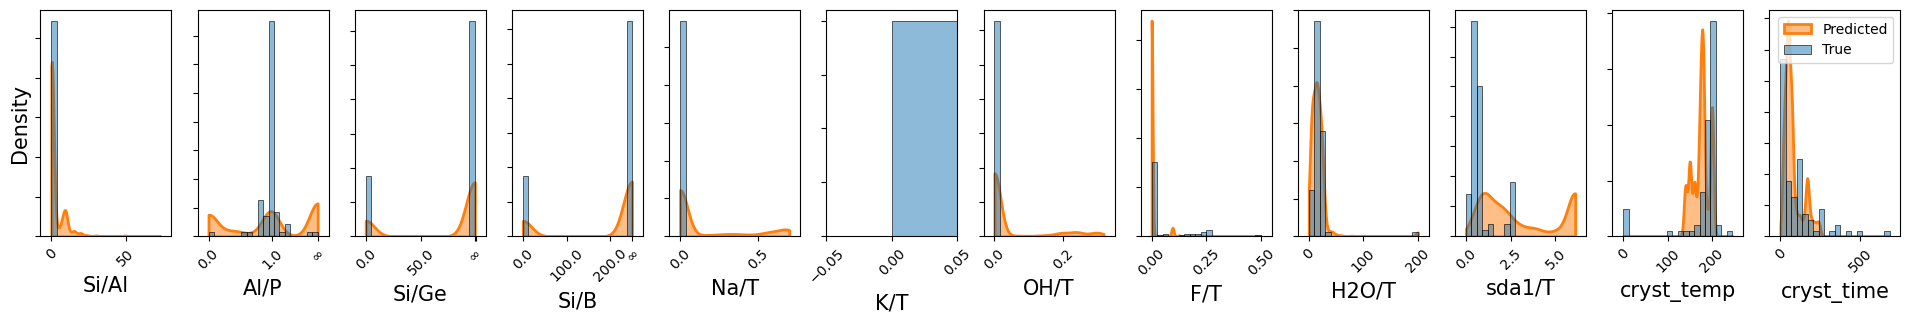

ATO CCCNCCC
MMD: 1.435647964477539
WSD: 0.056219765851565545


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_m

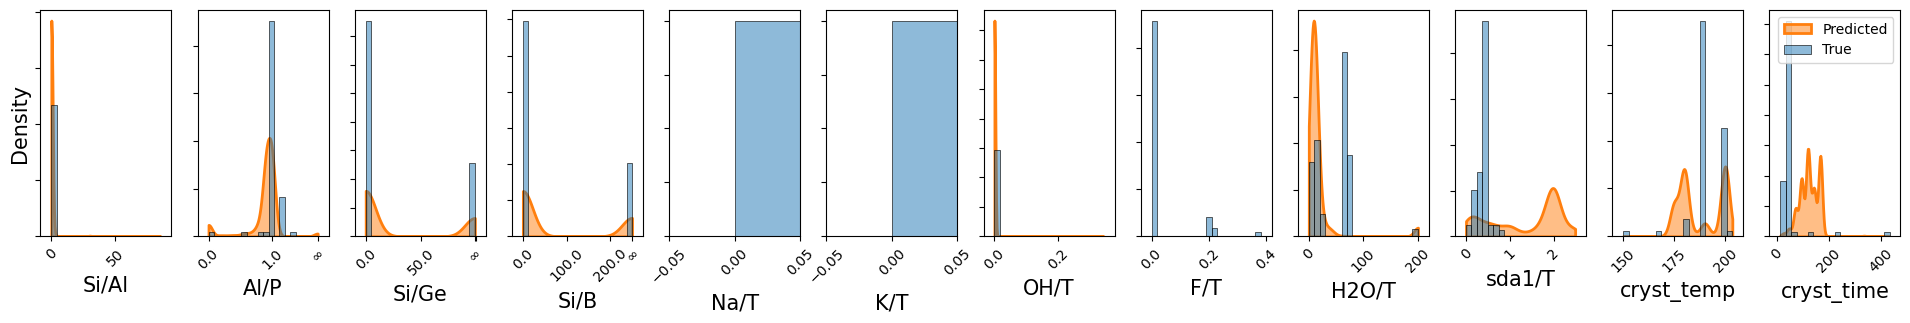

IWR C[N+](C)(C)CCCCCC[N+](C)(C)C
MMD: 0.9610767364501953
WSD: 0.3357997628279978


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


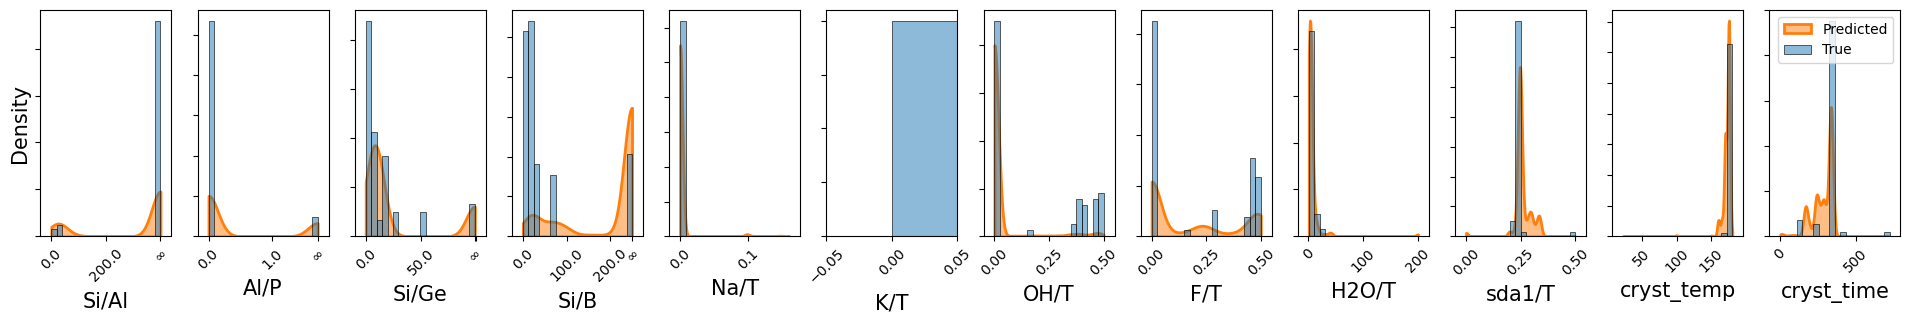

Mean MMD: 0.6641818046569824 Std MMD: 0.35459909581003246
Mean WSD: 0.1756500701713846 Std WSD: 0.08401169539924391


In [10]:
_, _ = eval_zeolite_osda(syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset, configs, eval=True, plot=True, print_metrics=True, num_systems=10)